# Implicit Quantile Networks (IQN)

## Introduction

Implicit Quantile Networks (IQN) is an advanced distributional reinforcement learning algorithm that extends QR-DQN by learning a continuous mapping from quantile levels to quantile values. Introduced by Dabney et al. in 2018, IQN provides a more sample-efficient and flexible approach to modeling return distributions.

## Core Concepts

### Implicit Quantile Function

IQN learns a continuous function that maps quantile levels $\tau$ to their corresponding values:

$$ Z_{\theta}(s,a,\tau) \approx F^{-1}_{Z(s,a)}(\tau) $$

where:

- $F^{-1}_{Z(s,a)}$ is the inverse CDF of the return distribution
- $\tau \in [0,1]$ is any quantile level
- $\theta$ represents network parameters

### Network Architecture

1. **State Embedding**
   - Standard neural network layers process state s

2. **Quantile Embedding**
   - Cosine embedding for quantile levels:
     $\varphi_j(\tau) = \cos(\pi j \tau)$, $j=1,...,n$
   - Embedded through a small network

3. **Merged Processing**
   - Element-wise product of state and quantile embeddings
   - Final layers produce quantile values

### Training Objective

The loss function is similar to QR-DQN but with sampled quantile levels:

$$ L(\theta) = \mathbb{E}[\sum_i \sum_j \rho_{\tau_i}(r + \gamma Z_{\theta}(s',a',\tau_j) - Z_{\theta}(s,a,\tau_i))] $$

where $\tau_i, \tau_j$ are sampled uniformly from $[0,1]$.

## Training Process

1. **Forward Pass**
   - Sample $K$ quantile levels $\tau \sim U[0,1]$
   - Input state $s$ and $\tau$ to network
   - Output corresponding quantile values

2. **Action Selection**
   - Sample quantiles for evaluation
   - Use mean value for ε-greedy policy

3. **Learning**
   - Sample transitions and quantile levels
   - Compute target quantile values
   - Update using quantile regression loss

## Advantages

1. **Sample Efficiency**
   - Learns continuous quantile function
   - Better generalization across quantiles
   - Requires fewer samples than QR-DQN

2. **Flexibility**
   - Can evaluate any quantile level
   - Adapts to different risk preferences
   - Better distribution approximation

3. **Computational Efficiency**
   - Can use fewer quantile samples
   - O(K²) complexity where K < N
   - More efficient than QR-DQN

## Why IQN is Better

1. **Improved Generalization**
   - Learns continuous mapping
   - Better transfer between quantiles
   - More robust value estimates

2. **Risk-Sensitive Control**
   - Dynamic risk adjustment
   - Continuous risk preferences
   - Better exploration strategies

3. **Architecture Benefits**
   - Rich state-quantile interactions
   - Better feature learning
   - More expressive value distributions

## Limitations

1. **Architecture Complexity**
   - More complex than QR-DQN
   - More hyperparameters to tune
   - Requires careful implementation

2. **Training Stability**
   - Sensitive to embedding dimension
   - Can be unstable early in training
   - Requires proper initialization

3. **Computational Overhead**
   - Cosine embedding calculations
   - Multiple forward passes for evaluation
   - More complex than standard DQN

## Mathematical Details

### Cosine Embedding

The embedding function for quantile level $\tau$:

$$ \varphi_j(\tau) = \cos(\pi j \tau), j=1,...,n $$

### State-Quantile Fusion

$$ \psi(s,\tau) = \phi(s) \odot \varphi(\tau) $$

where $\odot$ denotes element-wise product.

### Risk-Sensitive Policy

For risk parameter $\alpha$:
$$ \pi_{\alpha}(s) = \text{argmax}_a \mathbb{E}_{\tau \sim f_{\alpha}}[Z_{\theta}(s,a,\tau)] $$

where $f_{\alpha}$ is a distribution over $\tau$ reflecting risk preference.

## References

1. Dabney, W., Ostrovski, G., Silver, D., & Munos, R. (2018). "Implicit quantile networks for distributional reinforcement learning." International Conference on Machine Learning.

2. Yang, D., Zhao, L., Lin, Z., Qin, T., Bian, J., & Liu, T. Y. (2019). "Fully parameterized quantile function for distributional reinforcement learning." Advances in Neural Information Processing Systems.

3. Dabney, W., Kurth-Nelson, Z., Uchida, N., Starkweather, C. K., Hassabis, D., Munos, R., & Botvinick, M. (2020). "A distributional code for value in dopamine-based reinforcement learning." Nature.


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from typing import Dict
import gymnasium as gym
from collections import deque
from typing import Tuple, Optional
import matplotlib.pyplot as plt

In [3]:
class ReplayBuffer:
    """Experience replay buffer for RL agents."""

    def __init__(self, maxlen: int = 100_000):
        """Initialize replay buffer.

        Args:
            maxlen (int): Maximum size of the buffer
        """
        self.buffer = deque(maxlen=maxlen)

    def append(
        self, experience: Tuple[np.ndarray, np.ndarray, np.ndarray, float, bool]
    ) -> None:
        """Add experience to buffer.

        Args:
            experience (tuple): (state, next_state, action, reward, done)
        """
        self.buffer.append(experience)

    def sample(
        self,
        batch_size: int,
        device: torch.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        ),
    ) -> Dict[str, torch.Tensor]:
        """Sample a batch of experiences.

        Args:
            batch_size (int): Size of batch to sample
            device (torch.device): Device to put tensors on

        Returns:
            dict: Dictionary containing batched experiences
        """
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, next_states, actions, rewards, dones = zip(
            *[self.buffer[idx] for idx in indices]
        )

        # Convert to torch tensors
        states = torch.FloatTensor(np.array(states)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        actions = torch.LongTensor(np.array(actions)).to(device)
        # One-hot encode actions
        actions_one_hot = torch.zeros(
            batch_size, actions.max().item() + 1, device=device
        )
        actions_one_hot.scatter_(1, actions.unsqueeze(1), 1)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        dones = torch.FloatTensor(np.array(dones)).to(device)

        return {
            "states": states,
            "next_states": next_states,
            "actions": actions_one_hot,
            "rewards": rewards,
            "dones": dones,
        }

    def __len__(self) -> int:
        return len(self.buffer)


In [4]:
IQN_CONFIG = {
    "hidden_dim": 128,
    "n_quantiles": 64,  # Number of quantiles
    "n_cos_embeddings": 128,  # Number of cosine embeddings
}


class IQNNet(nn.Module):
    """Implicit Quantile Network implementation."""

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        n_quantiles: int = IQN_CONFIG["n_quantiles"],
        n_cos_embeddings: int = IQN_CONFIG["n_cos_embeddings"],
        hidden_dim: int = IQN_CONFIG["hidden_dim"],
    ):
        """Initialize IQN Network.

        Args:
            state_dim (int): Dimension of state space
            action_dim (int): Dimension of action space
            n_quantiles (int): Number of quantile samples
            n_cos_embeddings (int): Number of cosine embeddings
            hidden_dim (int): Hidden layer dimension
        """
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_quantiles = n_quantiles
        self.n_cos_embeddings = n_cos_embeddings

        # State encoder
        self.state_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Cosine embedding network
        self.cos_embedding = nn.Linear(n_cos_embeddings, hidden_dim)

        # Final network
        self.final_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
        )

    def calc_cos_embedding(self, tau: torch.Tensor) -> torch.Tensor:
        """Calculate cosine embedding for given quantiles.

        Args:
            tau (torch.Tensor): Sampled quantiles

        Returns:
            torch.Tensor: Cosine embeddings
        """
        batch_size = tau.shape[0]
        n_tau = tau.shape[1]

        # Calculate cos(pi * i * tau) for i=1,...,n_cos_embeddings
        i_pi = torch.arange(1, self.n_cos_embeddings + 1, device=tau.device) * np.pi
        cos_tau = torch.cos(tau.unsqueeze(-1) * i_pi.view(1, 1, -1))

        return cos_tau.view(batch_size * n_tau, self.n_cos_embeddings)

    def forward(
        self, state: torch.Tensor, tau: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass of IQN.

        Args:
            state (torch.Tensor): State tensor
            tau (torch.Tensor, optional): Quantile values. If None, will sample.

        Returns:
            tuple: (quantile values, sampled taus)
        """
        batch_size = state.shape[0]

        # Sample tau if not provided
        if tau is None:
            tau = torch.rand(batch_size, self.n_quantiles, device=state.device)
        n_tau = tau.shape[1]

        # Get state features
        state_features = self.state_net(state)  # [batch_size, hidden_dim]
        state_features = state_features.repeat_interleave(n_tau, dim=0)

        # Get quantile embedding
        cos_embedding = self.calc_cos_embedding(
            tau
        )  # [batch_size * n_tau, n_cos_embeddings]
        tau_embedding = F.relu(
            self.cos_embedding(cos_embedding)
        )  # [batch_size * n_tau, hidden_dim]

        # Combine state and quantile embeddings
        combined = state_features * tau_embedding

        # Get quantile values for each action
        quantiles = self.final_net(combined)  # [batch_size * n_tau, action_dim]
        quantiles = quantiles.view(batch_size, n_tau, self.action_dim)

        return quantiles, tau

    @torch.no_grad()
    def get_action(self, state: np.ndarray) -> int:
        """Get action for given state.

        Args:
            state (np.ndarray): State array

        Returns:
            int: Selected action
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(next(self.parameters()).device)
        quantiles, _ = self.forward(state)
        expected_values = quantiles.mean(dim=1)
        return expected_values.argmax().item()


In [5]:
class IQNAgent:
    """Implicit Quantile Networks (IQN) agent."""

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        learning_rate: float = 0.0003,
        gamma: float = 0.99,
        device: torch.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        ),
        hidden_dim: int = IQN_CONFIG["hidden_dim"],
        n_quantiles: int = IQN_CONFIG["n_quantiles"],
        n_cos_embeddings: int = IQN_CONFIG["n_cos_embeddings"],
    ):
        super().__init__()
        self.action_dim = action_dim
        self.gamma = gamma
        self.device = torch.device(device)

        # Create networks
        self.online_net = IQNNet(
            state_dim=state_dim,
            action_dim=action_dim,
            hidden_dim=hidden_dim,
            n_quantiles=n_quantiles,
            n_cos_embeddings=n_cos_embeddings,
        ).to(self.device)

        self.target_net = IQNNet(
            state_dim=state_dim,
            action_dim=action_dim,
            hidden_dim=hidden_dim,
            n_quantiles=n_quantiles,
            n_cos_embeddings=n_cos_embeddings,
        ).to(self.device)

        self.target_net.load_state_dict(self.online_net.state_dict())
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=learning_rate)

    def choose_action(self, state: np.ndarray, epsilon: float = 0.0) -> int:
        if np.random.random() < epsilon:
            return np.random.randint(self.action_dim)
        return self.online_net.get_action(state)

    def train(self, batch: Dict[str, torch.Tensor]) -> float:
        states = batch["states"]
        next_states = batch["next_states"]
        actions = batch["actions"]
        rewards = batch["rewards"]
        dones = batch["dones"]

        # Calculate current quantile values
        current_quantiles, tau = self.online_net(states)
        actions_one_hot = actions.long()
        current_quantiles = torch.sum(
            current_quantiles * actions_one_hot.unsqueeze(1), dim=-1
        )

        # Calculate target quantile values
        with torch.no_grad():
            # Get greedy actions from online network
            next_quantiles, _ = self.online_net(next_states)
            next_actions = next_quantiles.mean(dim=1).argmax(dim=-1)
            next_actions_one_hot = F.one_hot(next_actions, self.action_dim).float()

            # Get target quantile values
            target_quantiles, _ = self.target_net(next_states)
            target_quantiles = torch.sum(
                target_quantiles * next_actions_one_hot.unsqueeze(1), dim=-1
            )

            # Calculate target values
            target_quantiles = (
                rewards.unsqueeze(1)
                + (1 - dones.unsqueeze(1)) * self.gamma * target_quantiles
            )

        # Calculate quantile huber loss
        diff = target_quantiles.unsqueeze(1) - current_quantiles.unsqueeze(2)
        huber_loss = torch.where(diff.abs() <= 1.0, 0.5 * diff.pow(2), diff.abs() - 0.5)

        quantile_loss = torch.abs(tau.unsqueeze(2) - (diff < 0).float()) * huber_loss
        loss = quantile_loss.mean()

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def update_target(self) -> None:
        self.target_net.load_state_dict(self.online_net.state_dict())


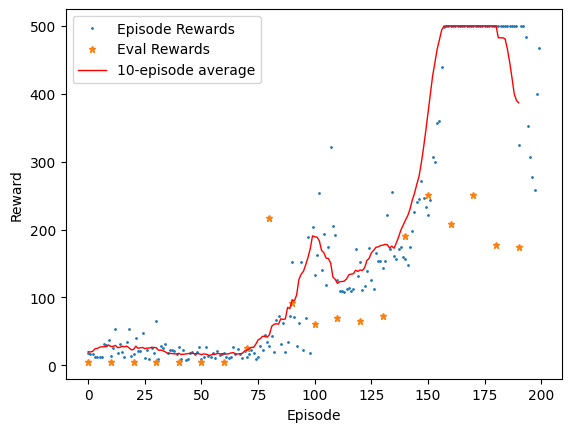

In [13]:
def train_iqn(env_name: str, device: str = "cuda") -> None:
    # Create environment
    env = gym.make(env_name)

    # Get state and action dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Initialize agent
    agent = IQNAgent(state_dim, action_dim, device=device)

    # Initialize replay buffer
    memory = ReplayBuffer(maxlen=100_000)

    # Training loop
    total_steps = 0
    episode_rewards = []
    eval_rewards = []
    eval_episodes = []

    # Training parameters
    episodes = 200
    eval_freq = 10
    n_eval_episodes = 4
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 5000
    min_memory_size = 1000
    target_update_freq = 100
    batch_size = 128

    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # Calculate epsilon for exploration
            epsilon = max(
                epsilon_end,
                epsilon_start
                - (epsilon_start - epsilon_end) * total_steps / epsilon_decay,
            )

            # Select action
            action = agent.choose_action(state, epsilon)

            # Take step in environment
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            episode_reward += reward
            total_steps += 1
            # Store experience in replay buffer
            memory.append(
                (
                    state,
                    next_state,
                    int(action),
                    reward,
                    done,
                )
            )

            # Update state
            state = next_state

            loss = 0.0

            # Train agent
            if len(memory) >= min_memory_size:
                batch = memory.sample(batch_size)
                loss = agent.train(batch)

                # Update target network
                if total_steps % target_update_freq == 0:
                    agent.update_target()

            if episode % 10 == 0:
                print(
                    f"Episode {episode:>{len(str(episodes))}}/{episodes} | "
                    f"Reward: {episode_reward:.2f} | "
                    f"Loss: {loss:.4f}",
                    end="\r",
                )

        # Track episode rewards
        episode_rewards.append(episode_reward)

        # Evaluate agent
        if episode % eval_freq == 0:
            eval_reward_list = []
            for _ in range(n_eval_episodes):
                state, _ = env.reset()
                eval_reward = 0
                done = False
                while not done:
                    with torch.no_grad():
                        action = agent.choose_action(state, epsilon=0.0)
                    state, reward, done, truncated, _ = env.step(action)
                    eval_reward += reward
                    done = done or truncated
                    eval_reward_list.append(eval_reward)

            mean_eval_reward = np.mean(eval_reward_list)
            eval_rewards.append(mean_eval_reward)
            eval_episodes.append(episode)

    # Close environment
    env.close()

    plt.plot(episode_rewards, "o", ms=1, label="Episode Rewards")
    plt.plot(
        np.arange(len(eval_rewards)) * eval_freq,
        eval_rewards,
        "*",
        ms=5,
        label="Eval Rewards",
    )
    plt.plot(
        np.convolve(episode_rewards, np.ones((10,)) / 10, mode="valid"),
        "r-",
        lw=1,
        label="10-episode average",
    )
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()


train_iqn("CartPole-v1")
